前処理 → 欠損値をそのままにした。

特徴量生成 → timeToReply(返信までの時間)をdays, hour, minute, secondに分けた。secondは全て0のデータだが精度の向上が見られたので追加した。

クラス不均衡に対する対処 → 返信時間の分布を見るとtestデータよりtrainデータの方が長い傾向にあるため、scoreの分布はtestデータの方が大きい値に偏っていることが想像できる。しかし、scoreの割合が著しく異なることは想像しづらいため、特に対処しなかった。


オーバーサンプリング → cvスコアが0.2ほど低下したため採用しなかった。

モデル選択 → LightGBMの精度が他より0.2ほど高かったため単体モデルとして採用した。

Seed値の探索 → Signateは経験上Seed値の探索が優位に働くことが多いため(データ数が少ないことが原因？)、cvスコアによる探索を行った。

最終選択 : LightGBM単体を採用し(データ数が少ないため)、パブリックスコアが高いSeed値モデルとcvスコアが高いSeed値モデルの2つで提出した。

In [2]:
# インポート
!pip install transformers torch
!pip install emoji
import spacy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import transformers
import sklearn
import emoji
import re
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')

# データの読み込み
train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)

# id列をインデックスに
train_df['id'] = train_df.index
test_df['id'] = test_df.index

# データの結合
train_df['flg'] = -1
test_df['flg'] = -2
df = pd.concat([train_df, test_df], axis=0)
# '*' を含む行を抽出(類似文字の確認用)
#print(df[df['review'].str.contains('*', regex=False)])



#### 前処理 ###



## timeToReply列 ##


# 空白を削除
df['timeToReply'] = df['timeToReply'].str.strip()

# timeToReply列をdays列とtime列に分割
df[['days', 'time']] = df['timeToReply'].str.split('days', n=1, expand=True)

# time列を:で分割してhour, minute, second列に分ける
df[['hour', 'minute', 'second']] = df['time'].str.split(':', expand=True)

# timeToReply列とtime列を削除
df = df.drop(['timeToReply', 'time'], axis=1)

# 空の文字列をNaNに変換
df['minute'].replace('', np.nan, inplace=True)

# 欠損値を保持しつつ浮動小数点型に変換
df['hour'] = df['hour'].astype(float)
df['minute'] = df['minute'].astype(float)
df['second'] = df['second'].astype(float)


## review列とreplyContent列(テキストデータ) ##

# レビューの長さを計算
#df['reviewLength'] = df['review'].apply(len)
# 返信の長さを計算
#df['replyLength'] = df['replyContent'].apply(len)

# 小文字にする
df['review'] = df['review'].str.lower()
df['replyContent'] = df['replyContent'].str.lower()

def remove_punctuation(text):
    # 特殊文字（感嘆符など）を取り除く
    return re.sub(r'[^\w\s]', '', text)

# 感嘆符を除去する
df['review'] = df['review'].apply(remove_punctuation)
df['replyContent'] = df['replyContent'].apply(remove_punctuation)

# 装飾文字や特殊記号のマッピング辞書
mapping_dict = {
    '🅑': 'B',
    '🅐': 'A',
    '🅖': 'G',
    '🅤': 'U',
    '🅢': 'S',
    '𝘉': 'B',
    '𝘦': 'e',
    '𝘯': 'n',
    '𝘦': 'e',
    '𝘳': 'r',
    '𝘪': 'i',
    '𝘯': 'n',
    '𝘢': 'a',
    '𝘴': 's',
    '𝙻': 'L',
    '𝚊': 'a',
    '𝚗': 'n',
    '𝚌': 'c',
    '𝚊': 'a',
    '𝚛': 'r',
    '²':  'tfidf___word1',
    '𝘚an𝘨a𝘵 𝘣a𝘨𝘶s': 'sanget bagus',
    '☆☆☆☆': '4 stars',
    '3¾36': 'custom rating',
    '𝘸': 'w',
    '𝙥': 'p',
    '𝙤': 'o',
    '𝚒': 'i',
    '𝘵': 't',
    '𝘫': 'j',
    '𝘥': 'd',
    '𝘶': 'u',
    '𝘮': 'm',
    '𝘨': 'g',
    '𝘹': 'x',
    '𝘩': 'h',
    '𝚎': 'e',
    '𝘣': 'b',
    '𝚜': 's',
    '𝘱': 'p',
    '𝘬': 'k',
    '𝚔': 'k',
    '𝘺': 'y',
    'ź': 'z',
    '𝘭': 'l',
    '𝙩': 't',
    '𝚕': 'l',
    'ᴗ': 'Satisfied',
    '만족된': 'Satisfied'
}

# 特殊文字や装飾文字をマッピングで置き換える関数
def replace_with_mapping(text, mapping):
    for key, value in mapping.items():
        text = text.replace(key, value)
    return text

# 絵文字をテキストに置き換える関数
def replace_emojis(text):
    return emoji.demojize(text, delimiters=("", ""))

# 不要な空白や重複文字を削除する関数
def clean_text(text):
    # 連続した文字の重複を削除
    text = re.sub(r'(\w)\1+', r'\1', text)
    # 不要な空白を削除
    text = ' '.join(text.split())
    return text

# review列とreplyContent列に対して前処理を適用
for col in ['review', 'replyContent']:
    # 装飾文字や特殊記号をマッピングで置き換える
    df[col] = df[col].apply(lambda x: replace_with_mapping(x, mapping_dict))
    # 絵文字をテキストに置き換え
    df[col] = df[col].apply(replace_emojis)
    # 小文字に変換
    df[col] = df[col].str.lower()
    # テキストをクリーンアップ
    df[col] = df[col].apply(clean_text)

'''
from textblob import TextBlob

# 感情スコアを計算する関数
def get_sentiment_score(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # -1（ネガティブ）から1（ポジティブ）までのスコア

# 感情スコアを計算して新しいカラムとして追加
df['sentimentScore'] = df['review'].apply(get_sentiment_score)


nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag

def count_pos_tags(text):
    tagged = pos_tag(word_tokenize(text))
    noun_count = sum(1 for word, tag in tagged if tag.startswith('NN'))
    verb_count = sum(1 for word, tag in tagged if tag.startswith('VB'))
    adj_count = sum(1 for word, tag in tagged if tag.startswith('JJ'))
    return noun_count, verb_count, adj_count
# 名詞、動詞、形容詞のカウント
df[['noun_count', 'verb_count', 'adj_count']] = df['review'].apply(lambda x: pd.Series(count_pos_tags(x)))

# ユニークな単語の数
df['unique_word_count'] = df['review'].apply(lambda x: len(set(x.split())))

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# VADERのインスタンスを作成
analyzer = SentimentIntensityAnalyzer()

# 感情スコアを計算してデータフレームに追加
def get_sentiment_score(text):
    score = analyzer.polarity_scores(text)
    return score['compound']

df['sentiment_score'] = df['replyContent'].apply(get_sentiment_score)
'''

# トークン化
df['review_token'] = df['review'].apply(word_tokenize)
df['replyContent_token'] = df['replyContent'].apply(word_tokenize)

# ストップワードの除去
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

df['review_token'] = df['review_token'].apply(remove_stopwords)
df['replyContent_token'] = df['replyContent_token'].apply(remove_stopwords)

# レンマタイゼーション(ステミングより優れていた)
def lemmatize_spacy(tokens):
    doc = nlp(' '.join(tokens))
    return [token.lemma_ for token in doc]
df['review_token'] = df['review_token'].apply(lemmatize_spacy)
df['replyContent_token'] = df['replyContent_token'].apply(lemmatize_spacy)

# トークンの結合
df['review_processed'] = df['review_token'].apply(lambda tokens: ' '.join(tokens))
df['replyContent_processed'] = df['replyContent_token'].apply(lambda tokens: ' '.join(tokens))

# TF-IDFベクトル化のためのベクトルライザーを初期化(BERT埋め込みより優れていた)
vectorizer_review = TfidfVectorizer()
vectorizer_reply = TfidfVectorizer()

# review_processedカラムをベクトル化（スパース行列として保持）
review_tfidf = vectorizer_review.fit_transform(df['review_processed'])

# replyContent_processedカラムをベクトル化（スパース行列として保持）
replyContent_tfidf = vectorizer_reply.fit_transform(df['replyContent_processed'])

# 元のDataFrameにベクトル化したデータを追加（スパース行列を直接結合）
# スパース行列をDataFrameに変換する前に列名を付ける
review_tfidf_df = pd.DataFrame.sparse.from_spmatrix(review_tfidf, index=df.index, columns=vectorizer_review.get_feature_names_out())
replyContent_tfidf_df = pd.DataFrame.sparse.from_spmatrix(replyContent_tfidf, index=df.index, columns=vectorizer_reply.get_feature_names_out())

# 元のDataFrameにベクトル化したデータをマージ
df = df.merge(review_tfidf_df.add_suffix('_review'), left_index=True, right_index=True)
df = df.merge(replyContent_tfidf_df.add_suffix('_replychinco'), left_index=True, right_index=True)

# 元の列を削除
df = df.drop(['review', 'replyContent', 'review_token', 'replyContent_token','review_processed', 'replyContent_processed'], axis=1)

# 重複列を削除
df = df.loc[:,~df.columns.duplicated()]

# 例外の列名を表示して削除
new_columns = []
for i, col in enumerate(df.columns):
    if not re.match(r'^[a-zA-Z0-9_]+$', col):
        print(f"Invalid column name: {col}")
        new_columns.append(f"feature_{i}")
    else:
        new_columns.append(col)
df.columns = new_columns



### 特徴量生成 ###



'''
# 新しい列 total_time を作成し、days、hour、minute を結合
df['total_time'] = df['days'] * 24 * 60 + df['hour'] * 60

# 元の列 days, hour, minute を削除
df = df.drop(columns=['days', 'hour'])

# 外れ値を検出するための関数
def detect_outliers(df, column):
    # 四分位範囲 (IQR) に基づく外れ値検出
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (df[column] < lower_bound) | (df[column] > upper_bound)
    '''



# 再分割
train_df = df[df['flg'] == -1]
test_df = df[df['flg'] == -2]
train_df = train_df.drop('flg', axis=1)
test_df = test_df.drop('flg', axis=1)

# 結果の表示
display(train_df.head())
display(test_df.head())

# float型に
train_df = train_df.astype(float)
test_df = test_df.astype(float)

# データの表示
display(train_df.head())
display(test_df.head())

# 不要な変数を削除してメモリを解放
del review_tfidf
del replyContent_tfidf
del df


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,score,thumbsUpCount,reviewCreatedVersion,id,days,hour,minute,second,01_review,01207_review,...,youshima_replychinco,yousora_replychinco,youswah_replychinco,youtedi_replychinco,youtika_replychinco,youwinky_replychinco,youyuka_replychinco,yudi_replychinco,yuka_replychinco,yuki_replychinco
0,0.0,0,33.0,0,0,5.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0,32.0,1,0,14.0,25.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0,33.0,2,0,0.0,41.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0,33.0,3,0,0.0,30.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0,33.0,4,0,15.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,score,thumbsUpCount,reviewCreatedVersion,id,days,hour,minute,second,01_review,01207_review,...,youshima_replychinco,yousora_replychinco,youswah_replychinco,youtedi_replychinco,youtika_replychinco,youwinky_replychinco,youyuka_replychinco,yudi_replychinco,yuka_replychinco,yuki_replychinco
8767,NaN,0,33.0,8767,0,2.0,45.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8768,NaN,0,32.0,8768,0,7.0,30.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8769,NaN,0,33.0,8769,0,14.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8770,NaN,0,33.0,8770,0,6.0,31.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8771,NaN,0,NaN,8771,0,22.0,31.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,score,thumbsUpCount,reviewCreatedVersion,id,days,hour,minute,second,01_review,01207_review,...,youshima_replychinco,yousora_replychinco,youswah_replychinco,youtedi_replychinco,youtika_replychinco,youwinky_replychinco,youyuka_replychinco,yudi_replychinco,yuka_replychinco,yuki_replychinco
0,0.0,0.0,33.0,0.0,0.0,5.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,32.0,1.0,0.0,14.0,25.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,33.0,2.0,0.0,0.0,41.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,33.0,3.0,0.0,0.0,30.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,33.0,4.0,0.0,15.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,score,thumbsUpCount,reviewCreatedVersion,id,days,hour,minute,second,01_review,01207_review,...,youshima_replychinco,yousora_replychinco,youswah_replychinco,youtedi_replychinco,youtika_replychinco,youwinky_replychinco,youyuka_replychinco,yudi_replychinco,yuka_replychinco,yuki_replychinco
8767,NaN,0.0,33.0,8767.0,0.0,2.0,45.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8768,NaN,0.0,32.0,8768.0,0.0,7.0,30.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8769,NaN,0.0,33.0,8769.0,0.0,14.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8770,NaN,0.0,33.0,8770.0,0.0,6.0,31.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8771,NaN,0.0,NaN,8771.0,0.0,22.0,31.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


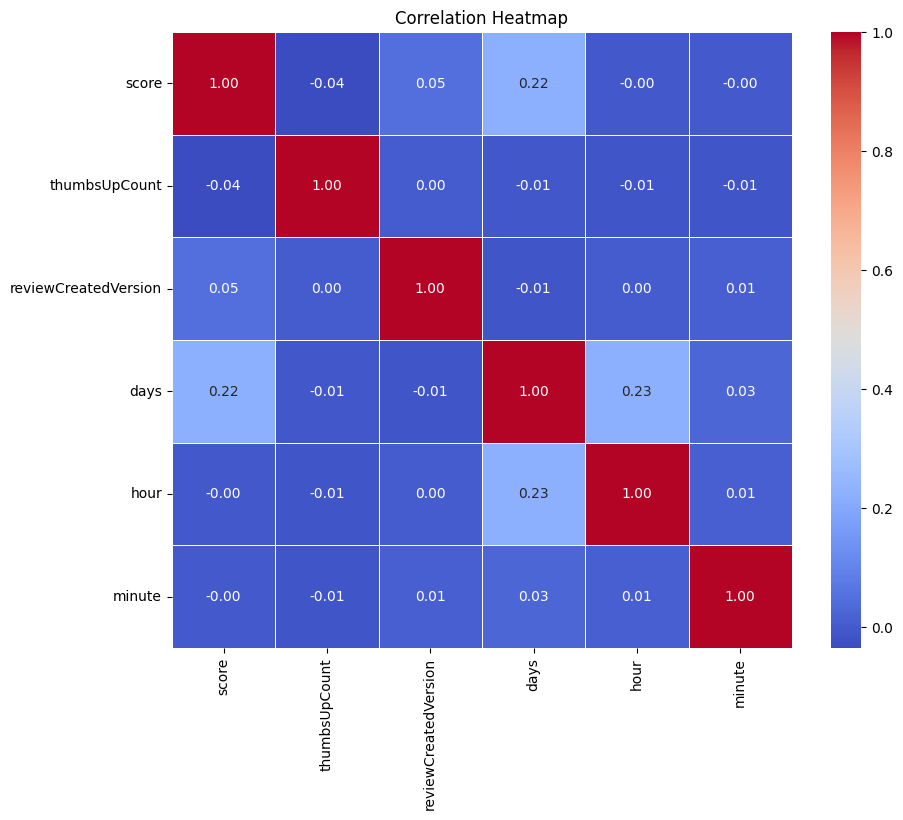

score
4.0    0.678795
0.0    0.181020
3.0    0.073799
2.0    0.034333
1.0    0.032052
Name: proportion, dtype: float64


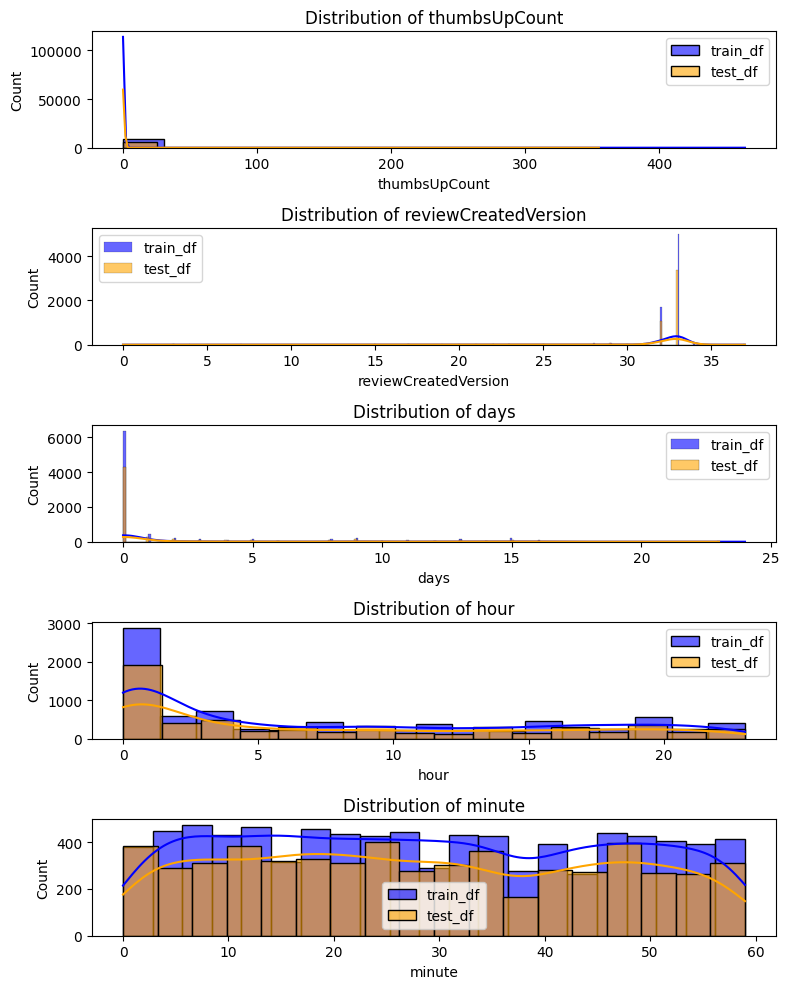

"\nimport pandas as pd\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.cluster import KMeans\nimport matplotlib.pyplot as plt\n\n# days, hours, minutes を足して新しい列を作成\ntrain_df['total_minutes'] = train_df['days'] * 24 * 60 + train_df['hour'] * 60 + train_df['minute']\n# NaNを-500に\ntrain_df['total_minutes'] = train_df['total_minutes'].fillna(-500)\n\n\n# K-meansクラスタリングの適用\nkmeans = KMeans(n_clusters=2, random_state=0)  # クラスタ数は適宜調整\nclusters = kmeans.fit_predict(scaled_data)\n\n# クラスタリング結果をデータフレームに追加\ntrain_df['total_minutes'] = clusters\n\n# エルボー法で最適なクラスタ数を決定するコード（オプション）\nsse = []\nfor k in range(1, 11):\n    kmeans = KMeans(n_clusters=k, random_state=0)\n    kmeans.fit(scaled_data)\n    sse.append(kmeans.inertia_)\n\nplt.plot(range(1, 11), sse)\nplt.xlabel('Number of clusters')\nplt.ylabel('SSE')\nplt.title('Elbow Method')\nplt.show()\n"

In [3]:

### データの確認 ###



import matplotlib.pyplot as plt
import seaborn as sns

# 相関行列を作成する列を選択
columns = ['score', 'thumbsUpCount', 'reviewCreatedVersion', 'days', 'hour', 'minute']
corr_matrix = train_df[columns].corr()

# ヒートマップを作成
plt.figure(figsize=(10, 8))  # サイズは調整可能
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

train_df.describe()

# 各クラスの割合も確認したい場合
print(train_df['score'].value_counts(normalize=True))

# train_dfとtest_dfの分布を比較するプロット
# カラム名のリスト
columns = ['thumbsUpCount', 'reviewCreatedVersion', 'days', 'hour', 'minute']

# プロットの設定
plt.figure(figsize=(15, 10))

for i, column in enumerate(columns, 1):
    plt.subplot(len(columns), 2, 2 * i - 1)
    sns.histplot(train_df[column], kde=True, color='blue', label='train_df', alpha=0.6)
    sns.histplot(test_df[column], kde=True, color='orange', label='test_df', alpha=0.6)
    plt.title(f'Distribution of {column}')
    plt.legend()

plt.tight_layout()
plt.show()

'''
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# days, hours, minutes を足して新しい列を作成
train_df['total_minutes'] = train_df['days'] * 24 * 60 + train_df['hour'] * 60 + train_df['minute']
# NaNを-500に
train_df['total_minutes'] = train_df['total_minutes'].fillna(-500)


# K-meansクラスタリングの適用
kmeans = KMeans(n_clusters=2, random_state=0)  # クラスタ数は適宜調整
clusters = kmeans.fit_predict(scaled_data)

# クラスタリング結果をデータフレームに追加
train_df['total_minutes'] = clusters

# エルボー法で最適なクラスタ数を決定するコード（オプション）
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()
'''

In [4]:
# LightGBM(1549, 3079: 0.9321, 3411: 0.9325, 3096: 0.9324) ←各seed値のcvスコア
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold

def qwk_score(y_true, y_pred):
    """
    Quadratic Weighted Kappa (QWK) のスコアを計算する関数
    """
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')
# 特徴量とターゲットの分離
X = train_df.drop(columns=['id', 'score'])
y = train_df['score']

# LightGBMのパラメータ設定
params = {
    'objective': 'multiclass',
    'num_class': 5,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'random_state': 1549,
}

# StratifiedKFoldでのクロスバリデーション
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
qwk_scores = []

for train_index, valid_index in kf.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # LightGBM用データセット
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    # モデルの学習
    bst = lgb.train(params,
                     train_data,
                     valid_sets=[valid_data],
                     num_boost_round=1000,)

    # 予測
    y_pred = bst.predict(X_valid, num_iteration=bst.best_iteration)
    y_pred_max = np.argmax(y_pred, axis=1)

    # QWKスコアの計算
    qwk = qwk_score(y_valid, y_pred_max)
    qwk_scores.append(qwk)
    print(f'Fold QWK Score: {qwk:.4f}')

# 平均QWKスコアの表示
print(f'Mean QWK Score: {np.mean(qwk_scores):.4f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27086
[LightGBM] [Info] Number of data points in the train set: 7013, number of used features: 693
[LightGBM] [Info] Start training from score -1.709536
[LightGBM] [Info] Start training from score -3.439420
[LightGBM] [Info] Start training from score -3.370724
[LightGBM] [Info] Start training from score -2.607478
[LightGBM] [Info] Start training from score -0.387308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [5]:
# seedの探索
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
import random

def qwk_score(y_true, y_pred):
    """
    Quadratic Weighted Kappa (QWK) のスコアを計算する関数
    """
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# 特徴量とターゲットの分離
X = train_df.drop(columns=['id', 'score'])
y = train_df['score']

# ランダムに選んだモデルのrandom_stateのリスト
model_seeds = random.sample(range(4000, 5000), 70)  # 0から99の中から10個のランダムなseedを選択

seed_qwk_scores = []

for seed in model_seeds:
    # LightGBMのパラメータ設定
    params = {
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'random_state': seed  # モデルのrandom_stateを設定
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # KFoldのrandom_stateは固定
    qwk_scores = []

    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        # LightGBM用データセット
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

        # モデルの学習
        bst = lgb.train(params,
                        train_data,
                        valid_sets=[valid_data],
                        num_boost_round=1000)

        # 予測
        y_pred = bst.predict(X_valid, num_iteration=bst.best_iteration)
        y_pred_max = np.argmax(y_pred, axis=1)

        # QWKスコアの計算
        qwk = qwk_score(y_valid, y_pred_max)
        qwk_scores.append(qwk)

    # 平均QWKスコアの計算
    mean_qwk = np.mean(qwk_scores)
    seed_qwk_scores.append((seed, mean_qwk))
    print(f'Model Seed {seed} Mean QWK Score: {mean_qwk:.4f}')

# モデルのrandom_stateと平均QWKスコアのリストを表示
print("Model Seed: Mean QWK Score List")
for seed, mean_qwk in seed_qwk_scores:
    print(f"Model Seed {seed}: {mean_qwk:.4f}")


KeyboardInterrupt: 

In [6]:
# 提出用
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

def qwk_score(y_true, y_pred):
    """
    Quadratic Weighted Kappa (QWK) のスコアを計算する関数
    """
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# 特徴量とターゲットの分離
X = train_df.drop(columns=['id', 'score'])
y = train_df['score']

# LightGBMのパラメータ設定
params = {
    'objective': 'multiclass',
    'num_class': 5,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'random_state': 3096
}

# 全データでモデルを学習
train_data = lgb.Dataset(X, label=y)

bst = lgb.train(params,
                 train_data,
                 num_boost_round=1000,
                )

# 特徴量の重要度を取得
importance = bst.feature_importance(importance_type='split')
feature_names = X.columns

# 特徴量の重要度をデータフレームに変換
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

# テストデータの予測
X_test = test_df.drop(columns=['id', 'score'], errors='ignore')
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_labels = np.argmax(y_pred, axis=1)  # 予測ラベルを取得

# 予測結果を投稿用CSVファイルに保存
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'score': y_pred_labels
})

submission_df['id'] = submission_df['id'].astype(int)

# CSVファイルに保存（ヘッダー無し）
submission_df.to_csv('submission.csv', index=False, header=False)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32456
[LightGBM] [Info] Number of data points in the train set: 8767, number of used features: 792
[LightGBM] [Info] Start training from score -1.709149
[LightGBM] [Info] Start training from score -3.440395
[LightGBM] [Info] Start training from score -3.371640
[LightGBM] [Info] Start training from score -2.606404
[LightGBM] [Info] Start training from score -0.387435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [27]:
# 提出用(複数のシードでスタッキング、メタモデルはロジスティック回帰)
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold

# QWKスコア計算関数
def qwk_score(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# 特徴量とターゲットの分離
X = train_df.drop(columns=['id', 'score'])
y = train_df['score']

# テストデータ準備
X_test = test_df.drop(columns=['id', 'score'], errors='ignore')

# LightGBMのパラメータ設定
params = {
    'objective': 'multiclass',
    'num_class': 5,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# スタッキングのためのLightGBMモデルを3つの異なるseedで学習
seeds = [3411, 1549, 61]
train_meta = np.zeros((X.shape[0], len(seeds)))
test_meta = np.zeros((X_test.shape[0], len(seeds)))

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, seed in enumerate(seeds):
    params['random_state'] = seed
    test_meta_fold = np.zeros((X_test.shape[0], kf.get_n_splits()))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # LightGBMモデルの学習
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        bst = lgb.train(params,
                        train_data,
                        num_boost_round=1000,
                        valid_sets=[train_data, val_data],
                       )

        # メタ特徴量用の予測値
        val_pred = bst.predict(X_val, num_iteration=bst.best_iteration)
        train_meta[val_idx, i] = np.argmax(val_pred, axis=1)

        # テストデータの予測値
        test_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
        test_meta_fold[:, fold] = np.argmax(test_pred, axis=1)

    test_meta[:, i] = test_meta_fold.mean(axis=1)

# メタモデルとしてロジスティック回帰を使用して学習
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(train_meta, y)

# テストデータでの予測
meta_pred = meta_model.predict(test_meta)

# 結果をCSVに保存
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'score': meta_pred
})

submission_df['id'] = submission_df['id'].astype(int)
submission_df['score'] = submission_df['score'].astype(int)

# CSVファイルに保存（ヘッダー無し）
submission_df.to_csv('submission.csv', index=False, header=False)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27086
[LightGBM] [Info] Number of data points in the train set: 7013, number of used features: 693
[LightGBM] [Info] Start training from score -1.709536
[LightGBM] [Info] Start training from score -3.439420
[LightGBM] [Info] Start training from score -3.370724
[LightGBM] [Info] Start training from score -2.607478
[LightGBM] [Info] Start training from score -0.387308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[